firstly make a csv document

In [3]:
import pandas as pd
import re
from datetime import datetime

def parse_finefoods_txt(path, encoding="latin-1"):
    records = []
    cur = None
    last_key = None  # track last key for multiline text continuation

    def flush():
        nonlocal cur
        if cur and ("productId" in cur or "text" in cur or "summary" in cur):
            records.append(cur)
        cur = None

    with open(path, "r", encoding=encoding, errors="strict") as f:
        for raw in f:
            line = raw.rstrip("\n")
            s = line.strip()

            #blank line: just continue (records are usually separated by blank lines)
            if not s:
                continue

            #if line starts a new record
            if s.startswith("product/productId:"):
                flush()
                cur = {}
                last_key = None
            #if we still haven't started a record but got other fields, start anyway
            if cur is None:
                cur = {}
            #normal "key: value" line
            if ":" in s:
                key, value = s.split(":", 1)
                key = key.strip()
                value = value.strip()
                last_key = key
                if key == "product/productId":
                    cur["productId"] = value
                elif key == "review/userId":
                    cur["userId"] = value
                elif key == "review/profileName":
                    cur["profileName"] = value

                elif key == "review/helpfulness":
                    # format like "4/5"
                    m = re.match(r"(\d+)\s*/\s*(\d+)", value)
                    if m:
                        cur["helpful_yes"] = int(m.group(1))
                        cur["helpful_total"] = int(m.group(2))
                    else:
                        cur["helpful_yes"] = None
                        cur["helpful_total"] = None

                elif key == "review/score":
                    try:
                        cur["score"] = float(value)
                    except:
                        cur["score"] = None

                elif key == "review/time":
                    # keep raw int + parsed date
                    try:
                        ts = int(value)
                        cur["time_unix"] = ts
                        cur["time"] = datetime.utcfromtimestamp(ts).date().isoformat()
                    except:
                        cur["time_unix"] = None
                        cur["time"] = None

                elif key == "review/summary":
                    cur["summary"] = value

                elif key == "review/text":
                    cur["text"] = value

                else:
                    # keep any other fields if they appear
                    cur[key] = value

            else:
                # No ":" in the line — treat as continuation of review/text (common in messy files)
                if last_key == "review/text":
                    cur["text"] = (cur.get("text", "") + "\n" + s).strip()
                else:
                    # otherwise, drop or store as "extra"
                    cur["extra"] = (cur.get("extra", "") + "\n" + s).strip()

    flush()
    return pd.DataFrame(records)

df = parse_finefoods_txt("finefoods.txt", encoding="latin-1")

print("rows:", len(df))
print(df.head(3))

df.to_csv("finefoods.csv", index=False)
print("saved: finefoods.csv")




/tmp/ipython-input-892598416.py:72: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  cur["time"] = datetime.utcfromtimestamp(ts).date().isoformat()


rows: 568454
    productId          userId                      profileName  helpful_yes  \
0  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian            1   
1  B00813GRG4  A1D87F6ZCVE5NK                           dll pa            0   
2  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"            1   

   helpful_total  score   time_unix        time                summary  \
0              1    5.0  1303862400  2011-04-27  Good Quality Dog Food   
1              0    1.0  1346976000  2012-09-07      Not as Advertised   
2              1    4.0  1219017600  2008-08-18  "Delight" says it all   

                                                text extra  
0  I have bought several of the Vitality canned d...   NaN  
1  Product arrived labeled as Jumbo Salted Peanut...   NaN  
2  This is a confection that has been around a fe...   NaN  
saved: finefoods.csv


In [26]:
# Setup
!pip -q install gensim nltk

import pandas as pd
import re
from collections import Counter
import math

from gensim import corpora, models

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df = pd.read_csv("finefoods.csv")
print(df.shape)
df.head()


/tmp/ipython-input-2433539037.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("finefoods.csv")


(568454, 11)


,productId,userId,profileName,helpful_yes,helpful_total,score,time_unix,time,summary,text,extra
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,1303862400,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,NaN
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,1346976000,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,1219017600,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,NaN
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2.0,1307923200,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,NaN
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,1350777600,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN


In [28]:
def preprocess_text(text):
    if pd.isna(text):
        return []

    text = str(text)
    text = text.lower()

    # delete meaningless things
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return words


In [29]:
# stamping
df_sample = df.sample(n=50000, random_state=42)

documents = []
all_texts = []

for t in df_sample["text"]:
    words = preprocess_text(t)
    if len(words) == 0:
        continue
    documents.append(words)
    all_texts += words

print("文档数:", len(documents))
print("总词数:", len(all_texts))


文档数: 50000
总词数: 1954069


In [30]:
dictionary = corpora.Dictionary(documents)
print("词汇表大小(过滤前):", len(dictionary))

# 过滤极稀有/极常见词（对 topic/TF-IDF 很重要）
dictionary.filter_extremes(no_below=10, no_above=0.5)
print("词汇表大小(过滤后):", len(dictionary))

# 全体词频（用 all_texts 做一个整体统计）
bow_all = dictionary.doc2bow(all_texts)
word_freq = [(dictionary.get(wid), freq) for wid, freq in bow_all]
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)

print("Top 30 words:")
for w, f in word_freq_sorted[:30]:
    print(w, f)


词汇表大小(过滤前): 40298
词汇表大小(过滤后): 8947
Top 30 words:
like 22363
good 17836
one 15745
taste 15153
coffee 14718
great 14699
product 13373
flavor 12976
tea 12455
food 11497
love 11263
would 10787
get 9457
really 8867
much 8134
amazon 8001
also 7538
time 7504
little 7423
use 7411
tried 6780
price 6756
best 6727
buy 6641
even 6587
find 6384
well 6366
make 6290
better 6140
try 6084


In [32]:
doc_bow = [dictionary.doc2bow(d) for d in documents]

doc_id = 0
wv = [(dictionary.get(wid), freq) for wid, freq in doc_bow[doc_id]]
wv_sorted = sorted(wv, key=lambda x: x[1], reverse=True)

print("doc_id =", doc_id)
for w, f in wv_sorted[:20]:
    print(w, f)


doc_id = 0
free 3
gluten 3
brands 2
cookies 2
sweet 2
true 2
best 1
bit 1
bunch 1
chocolate 1
chocolatey 1
couple 1
crunchy 1
filling 1
glutino 1
good 1
makes 1
means 1
might 1
real 1


In [33]:
from collections import Counter
def score_to_label(s):
    if pd.isna(s):
        return None
    try:
        s = float(s)
    except:
        return None
    if s >= 4:
        return "pos"
    if s <= 2:
        return "neg"
    return "neu"

df["label"] = df["score"].apply(score_to_label)

# distribution
label_counts = df["label"].value_counts(dropna=False)
print(label_counts)
print((label_counts / len(df)).round(4))


label
pos    443777
neg     82037
neu     42640
Name: count, dtype: int64
label
pos    0.7807
neg    0.1443
neu    0.0750
Name: count, dtype: float64


positive comment and negitive comment are very unbalanced,pos:neg=5:1,pos:(neg+ neu)=4:1 it reflects that in this case, people would morel ikely to leave a comment when food is good. more positive reviews gains more buying, and the good foods gets more purches probably.

In [35]:
#Sample for analysis
df_sample = df.dropna(subset=["text", "label"]).sample(n=50000, random_state=42)
print(df_sample["label"].value_counts())


label
pos    39105
neg     7104
neu     3791
Name: count, dtype: int64


In [36]:
stop_words = set(stopwords.words("english"))

# stopwords first round, do it once again later
domain_stop = {
    "like","one","would","really","get","got","also","much","even","well","make","made",
    "time","product","amazon","buy","bought","use","used","using","try","tried","find",
    #"good","great","best","better","love"
}
stop_words_ext = stop_words.union(domain_stop)
def preprocess_text(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    words = [w for w in words if (w not in stop_words_ext and len(w) > 2)]
    return words


In [37]:
pos_counter = Counter()
neg_counter = Counter()
neu_counter = Counter()
for _, row in df_sample.iterrows():
    words = preprocess_text(row["text"])
    if not words:
        continue
    if row["label"] == "pos":
        pos_counter.update(words)
    elif row["label"] == "neg":
        neg_counter.update(words)
    else:
        neu_counter.update(words)
print("pos token count:", sum(pos_counter.values()))
print("neg token count:", sum(neg_counter.values()))
print("neu token count:", sum(neu_counter.values()))
print("\nTop 30 POS words:")
for w, c in pos_counter.most_common(30):
    print(w, c)
print("\nTop 30 NEG words:")
for w, c in neg_counter.most_common(30):
    print(w, c)


pos token count: 1350162
neg token count: 271104
neu token count: 155352

Top 30 POS words:
good 14336
great 13231
coffee 11281
taste 10612
tea 10029
love 9970
flavor 9751
food 8744
best 6023
little 5844
price 5460
eat 4627
better 4527
dog 4475
cup 4304
chocolate 3971
first 3955
sugar 3941
water 3899
found 3870
bag 3831
free 3747
day 3698
sweet 3607
delicious 3464
drink 3382
store 3258
recommend 3209
two 3201
nice 3191

Top 30 NEG words:
taste 2773
coffee 2026
food 1964
good 1899
flavor 1723
tea 1400
first 1068
dog 965
box 940
bad 924
better 912
bag 882
eat 874
little 860
thought 856
know 823
great 801
two 793
water 791
could 780
cup 774
way 745
order 741
price 734
tastes 733
back 731
think 730
love 729
ordered 728
sugar 722


In [38]:
# show in both pos and neg
common_words = set(pos_counter.keys()) & set(neg_counter.keys())
common_freq = []
for w in common_words:
    total = pos_counter[w] + neg_counter[w]
    common_freq.append((w, pos_counter[w], neg_counter[w], total))

#ranking
common_freq_sorted = sorted(common_freq, key=lambda x: x[3], reverse=True)

print("Top 30 words appearing in BOTH POS and NEG:")
for w, pc, nc, total in common_freq_sorted[:30]:
    print(f"{w:15s} pos={pc:<7d} neg={nc:<7d} total={total}")


Top 30 words appearing in BOTH POS and NEG:
good            pos=14336   neg=1899    total=16235
great           pos=13231   neg=801     total=14032
taste           pos=10612   neg=2773    total=13385
coffee          pos=11281   neg=2026    total=13307
flavor          pos=9751    neg=1723    total=11474
tea             pos=10029   neg=1400    total=11429
food            pos=8744    neg=1964    total=10708
love            pos=9970    neg=729     total=10699
little          pos=5844    neg=860     total=6704
best            pos=6023    neg=415     total=6438
price           pos=5460    neg=734     total=6194
eat             pos=4627    neg=874     total=5501
dog             pos=4475    neg=965     total=5440
better          pos=4527    neg=912     total=5439
cup             pos=4304    neg=774     total=5078
first           pos=3955    neg=1068    total=5023
bag             pos=3831    neg=882     total=4713
water           pos=3899    neg=791     total=4690
chocolate       pos=3971    ne

both positive and negetive words has taste, coffee, food, flavor, tea...so words like "coffee, tea" implies there's good and bad coffee or tea,they could be topic words and people tend to use words like "good taste", "bad taste", "good flavor", "bad flavor". Some of these words like "one, first, two, could, think, way" are better to be deleted later when doing TF_IDF+LDA analysis.

In [39]:
import math

def top_discriminative_words(counter_a, counter_b, topn=50, alpha=1.0):
    """
    返回更偏向 A 的词（相对于 B）
    log((countA+alpha)/sumA) - log((countB+alpha)/sumB)
    """
    vocab = set(counter_a) | set(counter_b)
    sum_a = sum(counter_a.values())
    sum_b = sum(counter_b.values())

    scores = []
    for w in vocab:
        pa = (counter_a.get(w, 0) + alpha) / (sum_a + alpha*len(vocab))
        pb = (counter_b.get(w, 0) + alpha) / (sum_b + alpha*len(vocab))
        scores.append((w, math.log(pa) - math.log(pb), counter_a.get(w,0), counter_b.get(w,0)))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:topn], scores[-topn:][::-1]  # top for A, top for B






top_pos, top_neg = top_discriminative_words(pos_counter, neg_counter, topn=40, alpha=1.0)
print("\nWords more POS (vs NEG):")
for w, s, ca, cb in top_pos:
    print(f"{w:20s} score={s:+.3f}  pos={ca}  neg={cb}")
print("\nWords more NEG (vs POS):")
for w, s, ca, cb in top_neg:
    print(f"{w:20s} score={s:+.3f}  pos={ca}  neg={cb}")



Words more POS (vs NEG):
chipotle             score=+2.909  pos=81  neg=0
workout              score=+2.878  pos=158  neg=1
delightful           score=+2.872  pos=157  neg=1
arthritis            score=+2.859  pos=77  neg=0
greek                score=+2.833  pos=75  neg=0
brings               score=+2.813  pos=148  neg=1
addiction            score=+2.806  pos=73  neg=0
hooked               score=+2.784  pos=433  neg=5
magnesium            score=+2.739  pos=345  neg=4
munch                score=+2.677  pos=64  neg=0
cravings             score=+2.653  pos=126  neg=1
compliments          score=+2.630  pos=61  neg=0
burgers              score=+2.434  pos=50  neg=0
peppercorns          score=+2.434  pos=50  neg=0
mccann               score=+2.414  pos=49  neg=0
tastiest             score=+2.414  pos=49  neg=0
asks                 score=+2.394  pos=48  neg=0
hearty               score=+2.394  pos=146  neg=2
relaxing             score=+2.394  pos=97  neg=1
nursing              score=+2.394  p

from those words above, we can deduct that positive reviews tend to talk about more kinds of experiences and details, good feelings, while negative reviews usually focus on problems(even disease caused by food), risks, bad feelings or things that went wrong.

final stopwords

In [40]:
#delete more words
extra_stopwords = {
    "one", "first", "two", "could", "think", "way",
    "also", "really", "much", "even", "well",
    "make", "made", "get", "got", "use", "used",
    "time", "day", "days", "back", "know",
    "would", "still", "going", "went"
}
stop_words_ext = stop_words.union(extra_stopwords)

In [41]:
def preprocess_text(text):
    if pd.isna(text):
        return []

    #one more time, same as the last time
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()

    # stopwords+short words
    words = [w for w in words if w not in stop_words_ext and len(w) > 2]

    return words

In [42]:
#prepare corpus for TF-IDF,LDA

documents = [preprocess_text(t) for t in df_sample["text"]]
documents = [d for d in documents if d]  # remove empty

dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.5)

corpus_bow = [dictionary.doc2bow(d) for d in documents]

print("docs:", len(documents))
print("vocab:", len(dictionary))
print("corpus_bow:", len(corpus_bow))


docs: 50000
vocab: 8922
corpus_bow: 50000


In [45]:
#TF-IDF model

tfidf_model = models.TfidfModel(corpus_bow, smartirs="ntc")
corpus_tfidf = tfidf_model[corpus_bow]



In [46]:
from collections import defaultdict
tfidf_sum = defaultdict(float)
doc_count = 0

for doc in corpus_tfidf:
    doc_count += 1
    for wid, wgt in doc:
        tfidf_sum[wid] += wgt

tfidf_avg = [(dictionary[wid], tfidf_sum[wid] / doc_count) for wid in tfidf_sum]
tfidf_avg_sorted = sorted(tfidf_avg, key=lambda x: x[1], reverse=True)
print("Top 30 TF-IDF words:")
for w, s in tfidf_avg_sorted[:30]:
    print(w, round(s, 6))


Top 30 TF-IDF words:
coffee 0.023262
tea 0.020314
great 0.018633
good 0.018505
like 0.018363
product 0.016875
taste 0.016709
love 0.01662
flavor 0.015785
food 0.014058
amazon 0.012541
price 0.012303
best 0.011686
buy 0.011493
dog 0.010871
find 0.010552
little 0.010527
tried 0.010178
chocolate 0.01011
cup 0.01
better 0.009799
eat 0.009667
try 0.009104
order 0.008815
sugar 0.008666
bag 0.008393
sweet 0.008365
bought 0.008357
delicious 0.008331
drink 0.008293


we can see that the most informative words are still strongly related to food and drinks, such as coffee, tea, flavor, chocolate, and sugar. This suggests that the model is correctly capturing the main discussion topics in the reviews.

At the same time, general sentiment words like great, good, and love are still present, but they are no longer overwhelmingly dominant compared to simple word frequency counts. This means TF-IDF has partially reduced the weight of very common filler words while still keeping emotionally meaningful terms.

Overall, the vocabulary now looks more balanced: it includes both product-related terms and sentiment expressions

In [47]:
doc_id = 0
doc_tfidf = list(corpus_tfidf)[doc_id]
doc_sorted = sorted(
    [(dictionary[wid], wgt) for wid, wgt in doc_tfidf],
    key=lambda x: x[1],
    reverse=True
)
print("Doc", doc_id, "Top words:")
for w, s in doc_sorted[:15]:
    print(w, round(s, 6))

Doc 0 Top words:
gluten 0.382316
true 0.316052
free 0.287677
glutino 0.264554
cookies 0.253099
brands 0.244066
sooner 0.22206
chocolatey 0.219562
sandwich 0.191824
tooth 0.191044
sweet 0.187138
bunch 0.177378
satisfied 0.172848
means 0.16478
filling 0.157723


After applying TF-IDF, the top words for this review shift from simple repetition counts to more meaningful keywords. Instead of common positive words like good or best, the model now highlights more specific terms such as gluten, glutino, and cookies.

This shows that TF-IDF is doing its job — it reduces the weight of generic sentiment words and emphasizes the words that are more unique to this particular review. In this case, the review is clearly focused on gluten-free cookies and brand-specific details, which gives a much clearer picture of what the user is actually talking about rather than just how positive the tone is.

In [48]:
lda_model = models.LdaModel(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=8,
    random_state=42,
    passes=5
)
for i, topic in lda_model.print_topics(num_words=10):
    print("Topic", i, ":", topic)

Topic 0 : 0.007*"pill" + 0.007*"popchips" + 0.006*"matcha" + 0.005*"timely" + 0.004*"toddler" + 0.004*"prompt" + 0.004*"bears" + 0.004*"pomegranate" + 0.004*"loaf" + 0.004*"walmart"
Topic 1 : 0.028*"coffee" + 0.023*"tea" + 0.011*"cup" + 0.008*"flavor" + 0.007*"strong" + 0.007*"cups" + 0.006*"drink" + 0.006*"like" + 0.006*"taste" + 0.006*"good"
Topic 2 : 0.021*"hair" + 0.014*"senseo" + 0.008*"popper" + 0.008*"muffins" + 0.007*"cider" + 0.006*"shampoo" + 0.006*"gallon" + 0.006*"wrap" + 0.006*"lovers" + 0.006*"pecan"
Topic 3 : 0.007*"food" + 0.005*"product" + 0.004*"good" + 0.004*"like" + 0.003*"great" + 0.003*"sauce" + 0.003*"cat" + 0.003*"eat" + 0.003*"chicken" + 0.003*"cats"
Topic 4 : 0.009*"chips" + 0.008*"amazon" + 0.007*"order" + 0.007*"price" + 0.006*"product" + 0.006*"great" + 0.005*"buy" + 0.005*"find" + 0.005*"box" + 0.005*"good"
Topic 5 : 0.007*"taste" + 0.007*"sugar" + 0.006*"like" + 0.006*"sweet" + 0.005*"flavor" + 0.005*"chocolate" + 0.005*"great" + 0.005*"water" + 0.005*"go

topics are gotten, seems so good so far.
From the keyword patterns, the model is already separating reviews into fairly intuitive groups. For example, Topic 1 clearly revolves around coffee and tea, while Topic 6 is strongly about pet food and dog treats. Topic 5 looks like a sweet snacks / chocolate / sugar cluster, and Topic 4 is more about the shopping experience on Amazon, including price and ordering. Topic 3 feels like a more general food discussion, while some of the other topics (like 0, 2, and 7) appear to capture smaller or more mixed niches such as specific brands or less frequent product mentions. Overall, the topics are not random — they already align with real-world product categories and user concerns, which suggests the preprocessing and TF-IDF steps worked well and the LDA model is starting to reveal meaningful structure in the reviews.

The following steps assigns each review to its most likely topic, so now every comment has a topic label that we can use for later analysis.

In [52]:

#Step A: each review's topic frequency
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus_tfidf]

#Step B: find dominant topic
def get_main_topic(topics):
    if not topics:
        return None
    return max(topics, key=lambda x: x[1])[0]

df_sample["topic"] = [get_main_topic(t) for t in doc_topics]

print("Topic column added.")
print(df_sample["topic"].head())


Topic column added.
165256    5
231465    6
427827    3
433954    6
70260     3
Name: topic, dtype: int64


In [50]:
# Topic distribution
topic_dist = df_sample["topic"].value_counts(normalize=True).sort_index()
print(topic_dist)


topic
0    0.00148
1    0.19188
2    0.00122
3    0.31832
4    0.18258
5    0.22826
6    0.07454
7    0.00172
Name: proportion, dtype: float64


The topic distribution shows that most reviews are concentrated in a few major categories such as general food, sweets, beverages, and shopping experience.
Only a very small portion of reviews fall into niche or brand-specific topics, indicating that user discussions are highly focused rather than evenly spread across all food types.

# Topic × Sentiment

In [53]:
topic_sent = pd.crosstab(
    df_sample["topic"],
    df_sample["label"],
    normalize="index"
)

topic_sent


label,neg,neu,pos
topic,,,
0,0.106667,0.040000,0.853333
1,0.109975,0.080655,0.809370
2,0.203390,0.135593,0.661017
3,0.167389,0.079171,0.753440
4,0.180007,0.064710,0.755283
5,0.110635,0.077199,0.812166
6,0.120935,0.072830,0.806235
7,0.090909,0.034091,0.875000


Overall, most topics show a strong positive tendency.
Across almost all food categories, more than 75% of reviews are positive, which suggests that people are generally satisfied with food products on Amazon.
The main differences between topics are not about whether people like the food, but how strongly they like or dislike it.

In [54]:
topic_sent["pos"].sort_values(ascending=False)


,pos
topic,
7,0.875000
0,0.853333
5,0.812166
1,0.809370
6,0.806235
4,0.755283
3,0.753440
2,0.661017


Topics 7 and 0 have the highest positive ratios, meaning reviews in these categories are overwhelmingly favorable.
These topics likely represent either very niche products or highly loyal customer groups, where dissatisfaction is relatively rare.
In contrast, Topic 2 stands out with the lowest positive ratio, suggesting that products in this category receive more mixed reactions compared to others.

In [55]:
topic_sent["neg"].sort_values(ascending=False)


,neg
topic,
2,0.203390
4,0.180007
3,0.167389
6,0.120935
5,0.110635
1,0.109975
0,0.106667
7,0.090909


Topic 2 clearly has the highest negative ratio, indicating that this category tends to receive more complaints or dissatisfaction than others.
Topics 4 and 3 also show relatively higher negative proportions, which might be related to product quality inconsistency or purchasing experience issues.
On the other hand, Topic 7 has the lowest negative ratio, suggesting a more stable and consistently positive user perception.

<Axes: xlabel='topic'>

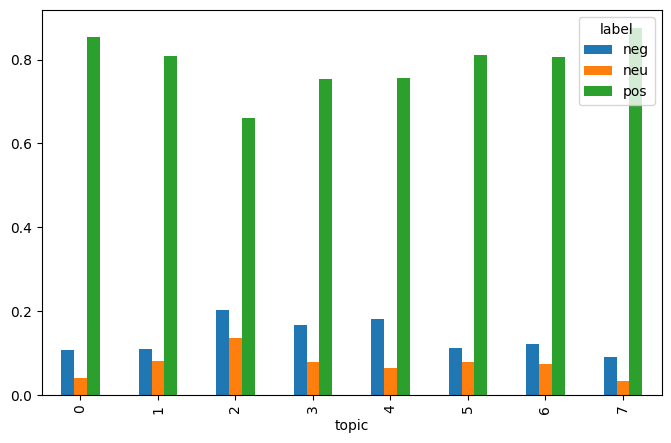

In [56]:
topic_sent.plot(kind="bar", figsize=(8,5))


The bar chart visually confirms that positive reviews dominate across all topics.
However, the variation in negative and neutral proportions reveals subtle differences in user satisfaction levels.
Rather than identifying “liked vs disliked foods,” the visualization highlights which categories generate stronger emotional responses and which ones are more controversial.

# **Topic 1 – Coffee / Tea / Drinks**

This topic mainly revolves around beverages such as coffee and tea.
The high positive ratio suggests that users generally enjoy drink-related products, possibly because taste preferences are more stable and brand loyalty is stronger in this category.
Complaints are relatively limited and often related to strength or flavor intensity rather than product failure。

# Topic 2 – Mixed / Product Quality / Unstable

This topic contains more scattered keywords and fewer clear food anchors, which may indicate product inconsistency or mixed categories.
The higher negative ratio suggests that dissatisfaction in this topic might stem from quality variation or mismatched expectations rather than a specific food type.Those data may be wrongly grouped into this data.

# Topic 3 – General Food / Cats / Sauce

This topic appears to represent general food discussions with some overlap into pet-related items.
The sentiment is mostly positive but less stable compared to beverage or snack topics. This part may indicate cats like those food, but the food is for human or pets is not identified.

# Topic 4 – Shopping / Amazon / Price

This topic focuses more on purchasing experience rather than food itself.
Keywords like order, price, and box indicate logistical or packaging concerns.
The relatively higher negative proportion suggests that dissatisfaction is often tied to delivery or pricing issues instead of product taste.


# Topic 5 – Sweet / Chocolate / Sugar

This topic centers on sweets and chocolate-based snacks.
The strong positive sentiment aligns with the generally pleasurable nature of sweet foods, which tend to show emotional satisfaction and enjoyment.


# Topic 6 – Pet Food / Treats
Pet food reviews show a stable positive trend.
Keywords such as dog, treats, and chew indicate functional and repetitive purchasing behavior, suggesting strong brand loyalty and consistent product satisfaction among pet owners.

# Topic × Time
The time-topic trend shows how user interest shifts across food categories over the years.

In [66]:
#year from date column
df_sample["year"] = pd.to_datetime(df_sample["time"], errors="coerce").dt.year

#1999-2012
df_sample = df_sample[df_sample["year"].between(1999, 2012)].copy()

years = list(range(1999, 2013))  # 1999..2012 inclusive


In [67]:
topic_year = pd.crosstab(df_sample["year"], df_sample["topic"])
#years without comment N/A make it 0
topic_year = topic_year.reindex(years, fill_value=0)
topic_year = topic_year.reindex(sorted(topic_year.columns), axis=1)
topic_year


topic,0,1,2,3,4,5,6,7
year,,,,,,,,
1999,0,0,0,0,0,0,0,0
2000,0,0,0,2,0,1,0,0
2001,0,0,0,0,0,0,0,0
2002,0,0,0,5,1,0,0,0
2003,0,3,0,4,1,0,1,0
2004,0,15,0,23,9,8,0,0
2005,0,22,0,36,27,23,8,1
2006,2,94,0,202,99,157,46,1
2007,5,326,1,615,445,514,124,2


Starting around 2006, the total number of reviews increases noticeably year by year.
This upward trend is especially clear for Topics 1, 3, 4, 5, and 6, where user participation grows much more rapidly over time.
It suggests that these categories attracted increasing attention and engagement as the platform became more popular.

In [68]:
topic_year_prop = topic_year.div(topic_year.sum(axis=1), axis=0)
#0/0 NaN
topic_year_prop = topic_year_prop.fillna(0)
topic_year_prop


topic,0,1,2,3,4,5,6,7
year,,,,,,,,
1999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,0.000000,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000
2001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002,0.000000,0.000000,0.000000,0.833333,0.166667,0.000000,0.000000,0.000000
2003,0.000000,0.333333,0.000000,0.444444,0.111111,0.000000,0.111111,0.000000
2004,0.000000,0.272727,0.000000,0.418182,0.163636,0.145455,0.000000,0.000000
2005,0.000000,0.188034,0.000000,0.307692,0.230769,0.196581,0.068376,0.008547
2006,0.003328,0.156406,0.000000,0.336106,0.164725,0.261231,0.076539,0.001664
2007,0.002461,0.160433,0.000492,0.302657,0.218996,0.252953,0.061024,0.000984


The proportional view shows that although the total number of reviews grows over time, the overall topic structure remains relatively stable.
Topics 1, 3, 4, and 5 consistently occupy the largest shares across years, indicating steady user interest in these food categories.
Smaller topics stay at very low proportions, suggesting they represent niche or brand-specific discussions rather than mainstream trends.

<Axes: xlabel='year'>

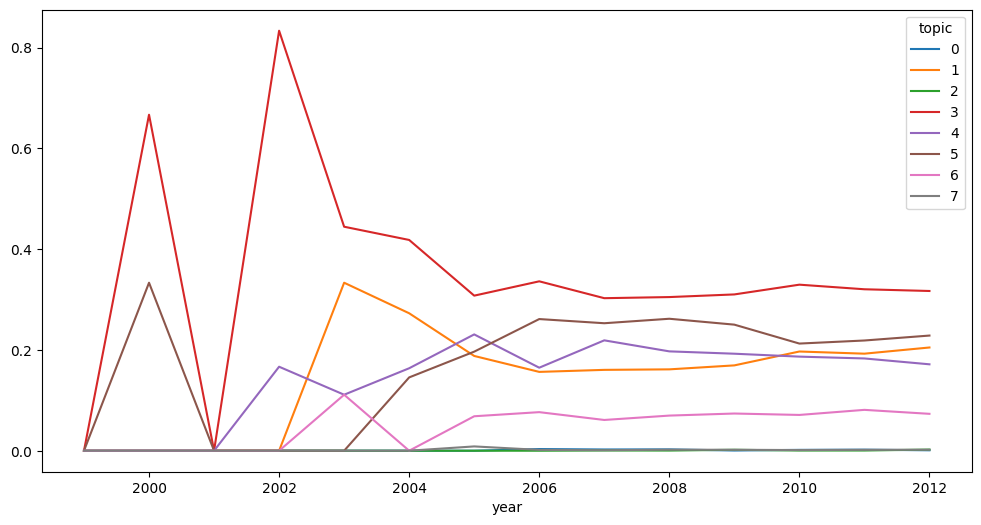

This line chart shows how topic proportions change over time. It becomes more meaningful when viewed together with the topic keywords.
Topic 3 (General Food / Cats / Sauce) consistently holds the largest share, suggesting that broad and everyday food discussions dominate over time rather than any single niche category.

Topic 1 (Coffee / Tea / Drinks) shows a steady and stable presence across years, which aligns with the idea that beverage products benefit from routine consumption and strong brand loyalty.
Topic 5 (Sweet / Chocolate / Sugar) also maintains a relatively high proportion, reflecting the emotional and habitual appeal of snack and dessert products.

Topic 4 (Shopping / Amazon / Price) fluctuates slightly but remains significant, indicating that logistics and purchasing experience are recurring concerns rather than temporary issues.
Topic 6 (Pet Food / Treats) grows gradually and stays stable, suggesting consistent demand driven by repetitive buying behavior from pet owners.

In contrast, smaller topics such as Topic 2 or Topic 0 remain minimal throughout the timeline, implying that they represent niche or mixed product discussions rather than mainstream consumer attention.